# **Tarea 1:** EDA y modelos bayesianos
## **Grupo 5** 
## **Integrantes:** 
 * Diego Irarrazaval
 * Pablo Paredes
 * Tomas Rojas

## Pregunta 1:  Carga y limpieza de datos.
### P1.1

In [287]:
import pandas as pd
import glob as glob
import numpy as np

`files_raw`, `files_estadisticas` y `files_asignacion` son listas que contienen las direcciones donde se encuentran los .csv a leer. 

In [288]:
files_raw = glob.glob('data/raw/**/*.csv', recursive = True)
files_estadisticas = glob.glob('data/estadisticas_upz/*.csv')
files_asignacion = glob.glob('data/asignacion_upz/*.csv')
files_estadisticas.sort()
data_raw = ([pd.read_csv(dir) for dir in files_raw])

### Creación del DataFrame y reporte de archivos furnished

In [289]:
'''
Creamos un data frame 'furnished', el cual tendrá dos columnas
1) 'url' para hacer el merge finalmente y obtener el data frame requerido
2) 'furnished' para contar cuantos datos están en archivos furnished y no en archivos all
'''

data_all = []
data_fur = []

for i in [0,2,4,6,8]:
    
    df1 = pd.read_csv(files_raw[i])
    df2 = pd.read_csv(files_raw[i+1])
    
    data_all.append(df1)
    data_fur.append(df2)
    
df_all = pd.concat(data_all)
df_fur = pd.concat(data_fur)
    
f1 = pd.merge(df_all, df_fur, how='outer', on='url', indicator='furnished')
furnished = f1[['url', 'furnished']].copy()

furnished.drop_duplicates(inplace = True)
furnished.reset_index(drop=True, inplace=True)

# Se reportan si hay datos de archivos furnished que no estén en all 

print('Hay '+ str(len(furnished[furnished['furnished'] == 'right_only'])) + ' datos de archivos furnished que no estan en all')

Hay 4 datos de archivos furnished que no estan en all


In [290]:
'''
Creamos el data frame 'data'
'''

df_aux = pd.concat([df_all, df_fur], ignore_index=True)

data = pd.merge(df_aux, furnished, how='inner', on='url')
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

# Se elimina la columna 'furnished' y se quitan los duplicados

data.drop('furnished', axis=1, inplace=True)
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

### P1.2 Limpieza de Columnas 

In [291]:
'''
Limpieza de columnas 'price', 'surface', 'n_rooms', 'n_bath'
'''

# Columna de precio ('price') tipo float

data.price = data['price'].str.replace('.', '')
data.price = data['price'].str.strip('$')
data.price = data['price'].map(float)

# Columna de área ('surface') tipo float

data.surface = data['surface'].replace('m2', '', regex=True)
data.surface = data['surface'].map(float)

In [292]:
# Notamos que en la columna de dormitorios ('n_rooms') existe la opción '5+'
# por lo que dejaremos esta columna como categórica

data.n_rooms.unique()

array(['3', 3.0, '5', '4', '2', '1', nan, 5.0, 4.0, '5+', 2.0, 1.0],
      dtype=object)

In [293]:
# Se crea un diccionario para pasar los datos numéricos de 'n_rooms' a string
# y se efectúa el mapeo

dic = {1.0: '1', 2.0:'2', 3.0: '3', 4.0:'4', 5.0:'5'}

data.n_rooms = data['n_rooms'].replace(dic)

In [294]:
# Como habían datos que solo se diferenciaban en la cantidad de dormitorios
# por el tipo de dato que eran (float o int), puede haberse creado duplicados. Se borran nuevamente los duplicados
# de data

data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

In [295]:
# Se hace lo mismo con la columnna de cantidad de baños ('n_bath')

data.n_bath.unique()

array(['2', 2.0, '1', '4', '3', nan, 3.0, '5', 4.0, 5.0, '5+', 1.0],
      dtype=object)

In [296]:
dic = {1.0: '1', 2.0:'2', 3.0: '3', 4.0:'4', 5.0:'5'}

data.n_bath.replace(dic)
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

In [297]:
'''
Separación de columna property_tipe|rent_type|location en tres columnas
con los nombres respectivos

'''

# Renombramos la columna

data.columns = ['PTL', 'price', 'n_rooms', 'n_bath', 'surface', 'details', 'url', 'metrocuadrado_index']

In [298]:
# Creamos las columnas y las llenamos

col = data['PTL'].str.split(', ', expand=True)

meta_col = col[0].str.split(' en ', expand=True)

# Nos aseguramos que hayan solo las siguientes opciones:
# -> 'Casa', 'Apartamento' para property_type
# -> 'Arriendo', 'Venta Y Arriendo' para rent_type

print(meta_col[0].unique())
print(meta_col[1].unique())

['Casa' 'Apartamento']
['Arriendo' 'Venta Y Arriendo']


In [299]:
# Formamos las nuevas columnas 'property_type', 'rent_type', 'location'

data['property_type'] = meta_col[0] 
data['rent_type'] = meta_col[1]
data['location'] = col[1]

# y retiramos la columna PTL

data.drop('PTL', axis=1, inplace=True)

In [300]:
# Finalmente quitamos la ciudad de 'location'

loc = col[1].str.split(' Bogotá', expand=True)
data.location = loc[0]

### P1.3 Precio por metro cuadrado y Cantidad de garages

In [301]:
'''
Agregamos una columna que represente el precio por metro cuadrado 'price_per_m2'

'''

data['price_per_m2'] = np.where(data['surface'] <= 0, float('nan'), data['price']/data['surface'])


In [302]:
'''
Obtenemos la cantidad de garajes y lo agregamos como columna también 'cant_garajes'

'''

garajes_list = data.url.str.split('-garajes', expand=True)
garajes_num = garajes_list[0].str.rsplit('-', n=1, expand=True)

# indices que tienen urls con info de la cantidad de garajes
ind = garajes_list[1].index[garajes_list[1].isna() == False]

# generación de nueva columna para después asignarla a la data
garajes_list[2] = np.nan
garajes_list[2].loc[ind] = garajes_num[1].loc[ind]

# agregación de la cantidad de garajes a la data (nan si no hay info)
data['cant_garajes'] = garajes_list[2]

C:\Users\Diego\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### P1.4 Clasificación Tipo de Producto

In [303]:
'''
Creamos una nueva columna 'clasif_prod_type' donde se representará la clasificación
de la vivienda con dígitos del 1 al 8 de acuerdo al enunciado

'''

data['clasif_prod_type'] = np.nan

data.clasif_prod_type.loc[(data.property_type == 'Casa') & (data.surface >= 80) & (data.surface < 120)] = 1
data.clasif_prod_type.loc[(data.property_type == 'Casa') & (data.surface >= 120) & (data.surface < 180)] = 2
data.clasif_prod_type.loc[(data.property_type == 'Casa') & (data.surface >= 180) & (data.surface < 240)] = 3
data.clasif_prod_type.loc[(data.property_type == 'Casa') & (data.surface >= 240) & (data.surface < 360)] = 4
data.clasif_prod_type.loc[(data.property_type == 'Casa') & (data.surface >= 360) & (data.surface < 460)] = 5
data.clasif_prod_type.loc[(data.property_type == 'Apartamento') & (data.surface >= 40) & (data.surface < 60)] = 6
data.clasif_prod_type.loc[(data.property_type == 'Apartamento') & (data.surface >= 60) & (data.surface < 80)] = 7
data.clasif_prod_type.loc[(data.property_type == 'Apartamento') & (data.surface >= 80) & (data.surface < 120)] = 8

data['clasif_prod_type'].astype('category')

0        NaN
1        1.0
2        1.0
3        1.0
4        NaN
        ... 
18386    6.0
18387    1.0
18388    6.0
18389    7.0
18390    8.0
Name: clasif_prod_type, Length: 18391, dtype: category
Categories (8, float64): [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

### P1.5 Obtención del código UPZ

In [304]:
'''
Se carga el archivo y se guarda en un dataframe data_upz
Luego, se realiza el merge para obtener el código para cada barrio

'''

# Se guarda la base de datos en un data frame
data_upz = pd.read_csv(files_asignacion[0], usecols = ['UPlCodigo', 'pro_location', 'UPlArea'])

# Se deja todo en minuscula para poder hacer el merge correctamente
data_upz.pro_location = data_upz.pro_location.map(str).map(lambda s: s.lower())
data.location = data.location.map(lambda s: s.lower())

In [305]:
#Se realiza el merge y se reportan cuantos datos no fueron asignados con código UPZ

data_merge = pd.merge(data, data_upz, left_on='location', right_on='pro_location', how='left')

print('A ' + str(sum(data_merge.UPlCodigo.isna())) + ' datos no se les puede asignar código UPZ')
print('lo cual es ' + str(sum(data_merge.UPlCodigo.isna())/len(data)*100) + '% de los datos')

A 2059 datos no se les puede asignar código UPZ
lo cual es 11.195693545756075% de los datos


In [306]:
# Creamos la columna 'UPZ' en data y le asignamos el código UPZ obtenido en data_merge

data['UPZ'] = data_merge['UPlCodigo']
data['UPZ_area'] = data_merge['UPlArea']

### P1.6 Fusión de datos con código UPZ

In [307]:
'''
Se cargan los datos en distintos data frames, para después hacerles merge con data
Luego, se crea una columna de densidad poblacional para cada código UTZ

'''

# Se cargan los datos en data frames respectivamente

data_pobl = pd.read_csv(files_estadisticas[0])
data_inseg = pd.read_csv(files_estadisticas[1])
data_verde = pd.read_csv(files_estadisticas[2])

In [308]:
data_pobl.head()

,Unnamed: 0,upz,nomupz,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc
0,0,UPZ11,SAN CRISTOBAL NORTE,68430,0.6,3.9,20.7,35.2,44.579934,17.931973
1,1,UPZ12,TOBERIN,50037,1.8,16.7,9.1,54.7,36.279630,5.420442
2,2,UPZ13,LOS CEDROS,102981,0.0,3.5,5.5,118.4,33.286852,3.250000
3,3,UPZ18,BRITALIA,69961,0.4,7.2,9.4,42.7,36.465059,9.439051
4,4,UPZ19,EL PRADO,121158,0.3,8.0,8.2,59.1,32.887202,5.406574


In [309]:
# Se quitan las columnas innecesarias de data_pobl y data_inseg

data_pobl.drop(['Unnamed: 0', 'nomupz'], axis=1, inplace=True)
data_inseg.drop(['Unnamed: 0', 'UPlNombre2'], axis=1, inplace=True)

In [310]:
# En data_verde se tiene que al código UPZ viene solo el número
# por lo tanto, hay que transformarlo al formato UPZ + número para poder hacer el merge correctamente

col = data_verde.cod_upz.map(int).map(str)
col_upz = 'UPZ' + col

data_verde.cod_upz = col_upz

# Se eliminan las columnas innecesarias
data_verde.drop(['Unnamed: 0', 'upz'], axis=1, inplace=True)

In [311]:
# Se realiza el merge, eliminando después las columnas innecesarias

data = pd.merge(data, data_pobl, left_on='UPZ', right_on='upz', how='left')
data.drop('upz', axis=1, inplace=True)
data = pd.merge(data, data_inseg, left_on='UPZ', right_on='UPlCodigo', how='left')
data.drop('UPlCodigo', axis=1, inplace=True)
data = pd.merge(data, data_verde, left_on='UPZ', right_on='cod_upz', how='left')
data.drop('cod_upz', axis=1, inplace=True)

In [312]:
# Finalmente, se crea la columna de densidad de población para cada código UTZ ('UTZ_density')

data['UTZ_density'] = data.personas/data.UPZ_area

## P2. EDA
### P2.1 Creacion de `estilo()`

In [313]:
import seaborn as sns
import matplotlib.pyplot as plt
#se crea diccionario que dará los valores a setear por defecto en el notebook
custom = {
    "font.size": 12,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 20,
    "axes.linewidth": 1.25,
    "grid.linewidth": 1,
    "lines.linewidth": 1.5,
    "lines.markersize": 6,
    "patch.linewidth": 1,
    "xtick.major.width": 1.25,
    "ytick.major.width": 1.25,
    "xtick.minor.width": 1,
    "ytick.minor.width": 1,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 4,
    "ytick.minor.size": 4,
    #'figure.figsize':(10.,8.),
    "figure.facecolor": "white",
    "axes.labelcolor": ".15",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.color": ".15",
    "ytick.color": ".15",
    "axes.axisbelow": True,
    "grid.linestyle": "--",
    "text.color": ".1",
    "patch.force_edgecolor": True,
    "image.cmap": "RdBu_r",
    "xtick.top": False,
    "ytick.right": False,
         }

#En las siguiente línea se implementa el diccionario personalizado como default para este notebook en seaborn
sns.set(rc=custom)

#se escoge una de las paletas que vienen con seaborn 
#(distinta a la que se usa por defecto) para el resto de notebook.
#sns.set_palette('Set2')

### P2.2 Perfilamiento: 
#### Naturaleza de las variables:
Antes del perfilamiento se hara un estudio de la naturaleza de las variables y se observaran algunas columnas 
para mejor entendimiento de los datos. 
Adicionalmente a estos estudios, se realizo lo siguiente:
```
import pandas_profiling as pp
pp.ProfileReport(data)

profile = data.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="output.html")
```
No se incluye en el notebook por el tipo de output que genera y debido a que tiene un largo tiempo de ejecucion. 

En primer lugar, es importante conocer que tipos de datos tienen las variables (o columnas).

In [314]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18393 entries, 0 to 18392
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   price                                    18393 non-null  float64
 1   n_rooms                                  18359 non-null  object 
 2   n_bath                                   18164 non-null  object 
 3   surface                                  18393 non-null  float64
 4   details                                  18275 non-null  object 
 5   url                                      18393 non-null  object 
 6   metrocuadrado_index                      18393 non-null  float64
 7   property_type                            18393 non-null  object 
 8   rent_type                                18393 non-null  object 
 9   location                                 18393 non-null  object 
 10  price_per_m2                             18377

Para comprender mejor las variables, se visualizan las primeras 5 filas con `head()`:

In [315]:
data.head()

,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index,property_type,rent_type,location,...,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc,indice_inseguridad,areas_verdes_perc,UTZ_density
0,1050000.0,3,2,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,Casa,Arriendo,la soledad norte,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3930000.0,3,2,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,Casa,Arriendo,ciudad salitre sur-oriental,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3930000.0,3,2,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,Casa,Arriendo,ciudad salitre sur-oriental,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,750000.0,3,1,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,Casa,Arriendo,villa de los alpes ii sector,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3400000.0,5,4,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,Casa,Arriendo,paris gaitan,...,156375.0,1.1,0.8,12.6,71.1,37.073314,8.40636,1.02916,37.852289,0.041894


Para ayudar a entender las variables numericas:

In [316]:
data.describe()

,price,surface,metrocuadrado_index,price_per_m2,clasif_prod_type,UPZ_area,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc,indice_inseguridad,areas_verdes_perc,UTZ_density
count,1.839300e+04,18393.000000,18393.00000,1.837700e+04,15493.000000,1.633400e+04,16334.000000,16334.000000,16334.000000,16334.000000,16334.000000,16334.000000,16334.000000,16334.000000,16334.000000,16334.000000
mean,8.916470e+06,114.312981,53.74343,9.788351e+04,6.179436,4.096954e+06,89179.774091,0.765881,15.286703,8.968501,106.355443,40.474601,7.951293,3.583395,32.323209,0.021656
std,1.339971e+08,110.109799,13.94925,1.532783e+06,1.753186,1.557667e+06,62329.384892,0.902056,24.499691,6.158096,45.982085,4.345747,6.795396,4.954806,14.286564,0.011396
min,0.000000e+00,0.000000,0.00000,0.000000e+00,1.000000,8.532359e+05,11570.000000,0.000000,0.100000,4.100000,9.800000,26.367889,1.034990,0.000000,5.274501,0.005101
25%,1.700000e+06,57.000000,44.30000,2.272727e+04,6.000000,2.851990e+06,52951.000000,0.000000,2.000000,4.300000,76.600000,38.443910,3.840225,1.161103,20.901367,0.012534
50%,2.600000e+06,77.000000,54.00000,3.134328e+04,7.000000,4.224476e+06,81261.000000,0.400000,7.900000,5.500000,127.300000,39.741321,5.401917,2.047782,25.466350,0.018877
75%,4.000000e+06,122.000000,63.40000,4.142857e+04,7.000000,4.745042e+06,115124.000000,1.500000,17.000000,11.400000,153.400000,44.667815,9.439051,3.383459,40.289476,0.025098
max,7.800000e+09,7400.000000,100.00000,5.494203e+07,8.000000,7.565953e+06,370385.000000,3.500000,125.700000,33.600000,153.400000,47.033692,50.669819,84.444444,86.427053,0.073815


#### Agrupacion por naturaleza:
A continuacion, se grafican las variables para entender como se distribuyen. Para esto, separamos las variables categoricas de las numericas. Ademas, debido a que las variables `'details','url','UPZ','location'` tienen muchos valores distintos, se dejaran en una categoria aparte:

In [317]:
names = ['numeric', 'categorical']

categorical = [col for col in data.columns if data[col].dtype == 'O']
categorical += set(['clasif_prod_type'])

others = ['details','url','UPZ','location']

numeric = list(set(data.columns) - set(categorical))

for col in others:
    categorical.remove(col)

mapping = [('numeric', col) for col in numeric]
mapping.extend([('categorical', col) for col in categorical])
mapping.extend([('others', col) for col in others])
'''
Se reordenan las columnas del dataframe para que coincidan con el esquema 
del multi indice
'''

data = data.reindex(columns = numeric + categorical + others)

Antes de comenzar el perfilamiento, veamos la cantidad de valores unicos de las columnas pertenecientes a others:

In [318]:
for col in others:
    n = len(data[col].unique())
    msg = 'Cantidad de valores unicos de ' + col + ' = ' + str(n)
    print(msg)

Cantidad de valores unicos de details = 14614
Cantidad de valores unicos de url = 14992
Cantidad de valores unicos de UPZ = 101
Cantidad de valores unicos de location = 632


Se observa que las 4 variables mencionadas anteriormente tienen cardinalidad mayor a 100 por lo que intentar graficarlo de la misma forma que se graficaran las variables categoricas no tiene tanto sentido. Lo que se propone para trabajar estas variables es realizar una codificacion para facilitar el analisis y agrupar donde sea necesario. Esto se realizara en particular para la variable `UPZ`. 

Las variables `details` y `url` se asumiran que no entregan informacion relevante (o nueva) sobre el precio por $metro^2$. Esto debido a que la informacion que estas columnas contiene se almacena en otras variables como el numero de banos o la cantidad de habitaciones, etc... 

#### Graficos de distribuciones univariadas de las variables:
Para esto, se implementan dos funciones: `plot_numeric_vars` y `plot_categorical_vars`. 

In [319]:
#Funcion para graficar Distribuciones univariadas de variables numericas:
def plot_numeric_vars(df, columns, title):
    '''
    Creaciion de graficos de Distribuciones Univariadas, recibe 
    el dataframe, las columnas a graficar y el 'SuperTitulo'    
    
    Args:
    ----------
    columns: list
        Lista con los nombres de las columnas de tipo numerico a graficar. 
        
    title: String
        Titulo
        
    Returns: None
        Se muestran los graficos
    
    
    Ejemplo de uso: 
    ------------
    
    Dado un DataFrame df:
    col_a_graficar = ['col1','col2','col3']
    
    plot_uni_dist(df,col_a_graficar,'Grafico de variables 1, 2, 3')
    
    '''
    sns.set(rc=custom)
    nplots = len(columns)
    ncols = 3
    nrows = int(np.ceil(nplots/ncols))
    
    # Grilla de subplots
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[17, 17])

    #Veamos si se deben remover plot:
    if nplots - ncols*nrows > 0:
        r = -(nplots - ncols*nrows)
        list(map(lambda a : a.remove(), ax[-1,r:]))
    
    fig.tight_layout()
    
    #Ponemos el titulo:
    fig.suptitle(title,
             fontsize=20,
             x=0.5,
             y=1.05)
    
    #Se recorre cada axis, para cada columna del dataframe, se genera un grafico 
    #distinto en funcion del tipo de dato.
    for axis, col in zip(ax.flatten(), columns):
        try :
            # Graficos para datos numericos
            sns.distplot(df[(col)], ax=axis, rug=True)

        except RuntimeError:
            sns.distplot(df[(col)], ax=axis, rug=True, kde=False)

        axis.set_xlabel(col, fontsize=15)

    # Se ajusta el espaciado interno entre subplots
    w, h = (.4, .4)
    plt.subplots_adjust(wspace=w, hspace=h)
    
    

In [320]:
#Funcion para graficar Distribuciones univariadas de variables numericas:
def plot_categorical_vars(df, columns, title, order = dict()):
    '''
    Creaciion de graficos de Distribuciones Univariadas recibe
    el dataframe, las columnas a graficar y el 'SuperTitulo'    
    
    Args:
    ----------
    columns: list
        Lista con los nombres de las columnas de tipo numerico a graficar. 
        
    title: String
        Titulo
        
    order: dict
        Diccionario que contiene como llave el nombre de la columna que se desea ordenar 
        y como valor una lista con las categorias correspondientes a esa columna en el orden 
        deseado. 
        
    Returns: None
        Se muestran los graficos
        
        
    Ejemplo de uso: 
    -------------
    Dado un DataFrame df:
    col_a_graficar = ['col1','col2','col3']
    cat_order = {
         'col1' = ['cat1','cat2','cat3', 'cat4']
         'col2' = [i for i in range(1,11)]
         'col3' = ['mujer', 'hombre', 'otro']
    }
    plot_uni_dist(df,col_a_graficar,'Grafico de variables categoricas', cat_order)
    -----------------
    
    Cuando no se incluye un diccionario order, se ordena por defecto. 
    
    
    '''
    sns.set(rc=custom)
    nplots = len(columns)
    ncols = 3
    nrows = int(np.ceil(nplots/ncols))
    
    # Grilla de subplots
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[17, 17])

    #Veamos si se deben remover plot:
    if nplots - ncols*nrows > 0:
        r = -(nplots - ncols*nrows)
        list(map(lambda a : a.remove(), ax[-1,r:]))
    
    fig.tight_layout()
    
    #Ponemos el titulo:
    fig.suptitle(title,
             fontsize=20,
             x=0.5,
             y=1.05)
    '''
    Se recorre cada axis, para cada columna del dataframe, se genera un grafico 
    distinto en funcion del tipo de dato.

    '''
    for axis, col in zip(ax.flatten(), columns):    
        # Graficos para datos tipos str
        try:
            sns.countplot(df[(col)], ax=axis, order = order[col])
        except:
            sns.countplot(df[(col)], ax=axis)
        axis.set_axis_on()
        axis.set_title(col, fontsize=15)
  
    
    # Se ajusta el espaciado interno entre subplots
    h, w = (.8, .8)
    plt.subplots_adjust(wspace=w, hspace=h)

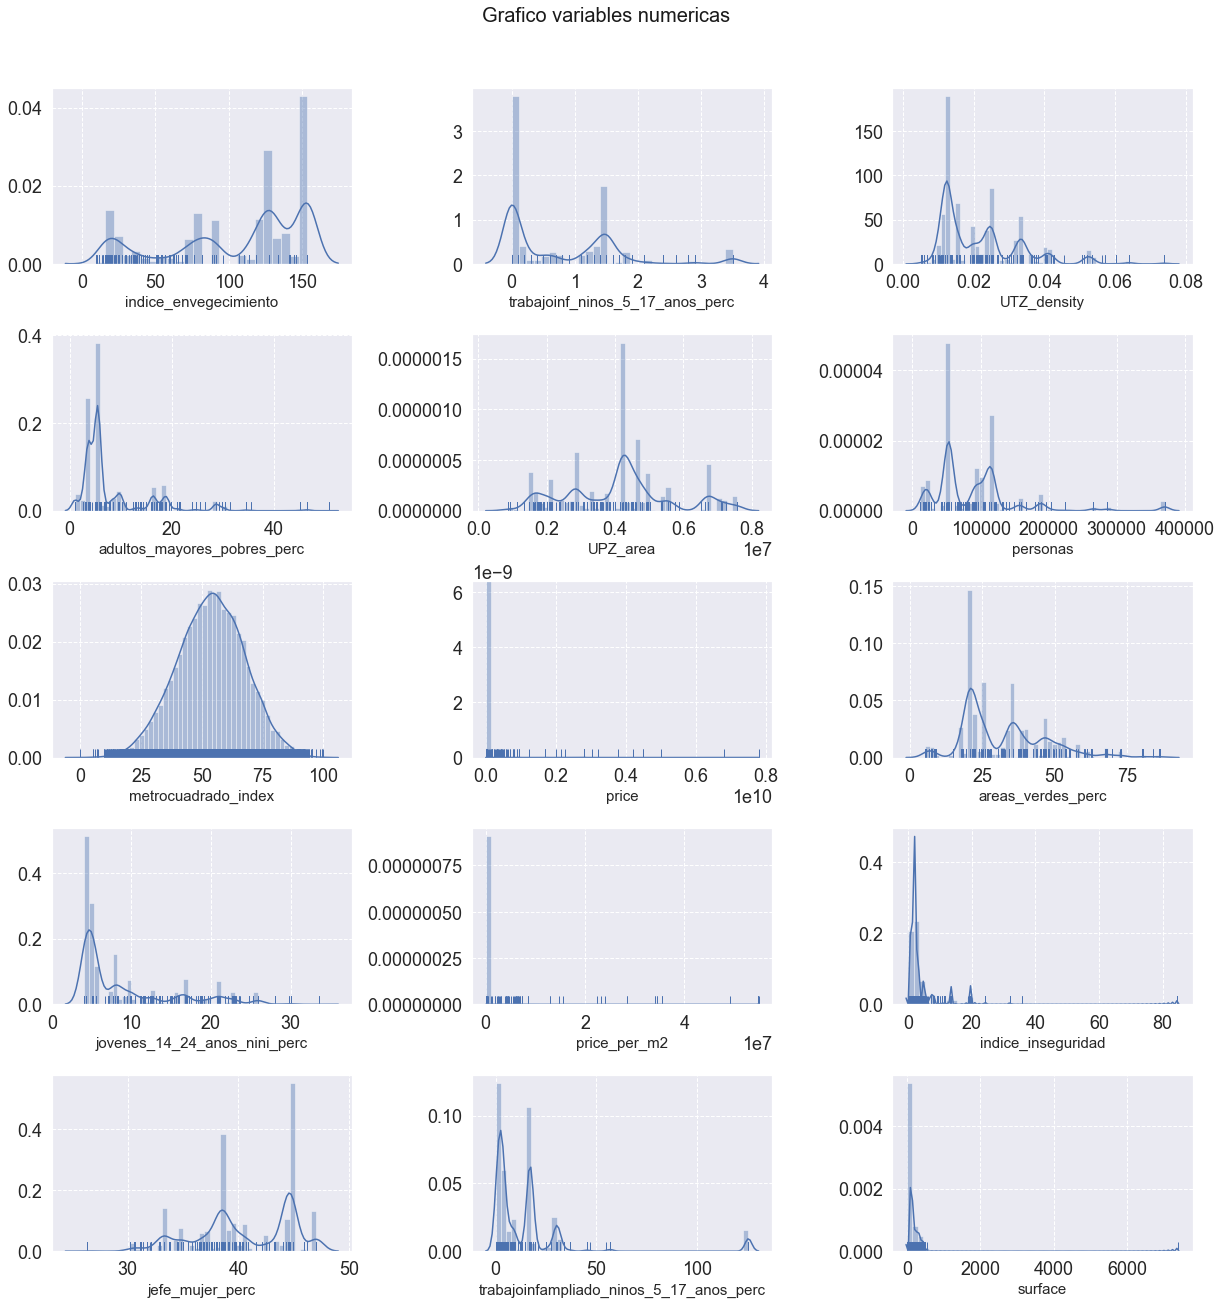

In [321]:
plot_numeric_vars(data,numeric,'Grafico variables numericas')

En primer lugar, sobresale la distribucion de `metrocuadrado_index`. Es la unica que no contiene grandes concentraciones. A simple vista, se podria aproximar con una distribucion Normal. Por otro lado, las variables `price`, `surface`, `indice_inseguridad` y `price_per_m2` presentan grandes concentraciones en zonas especificas. 

Para profundizar el analisis, luego de estudiar las distribuciones de las variables categoricas se estudiaran los comportamientos bivariados: relaciones entre variables con _scatterPlot_ y _violinPlot_. 

A continuacion se muestran las distribuciones de las variables categoricas:

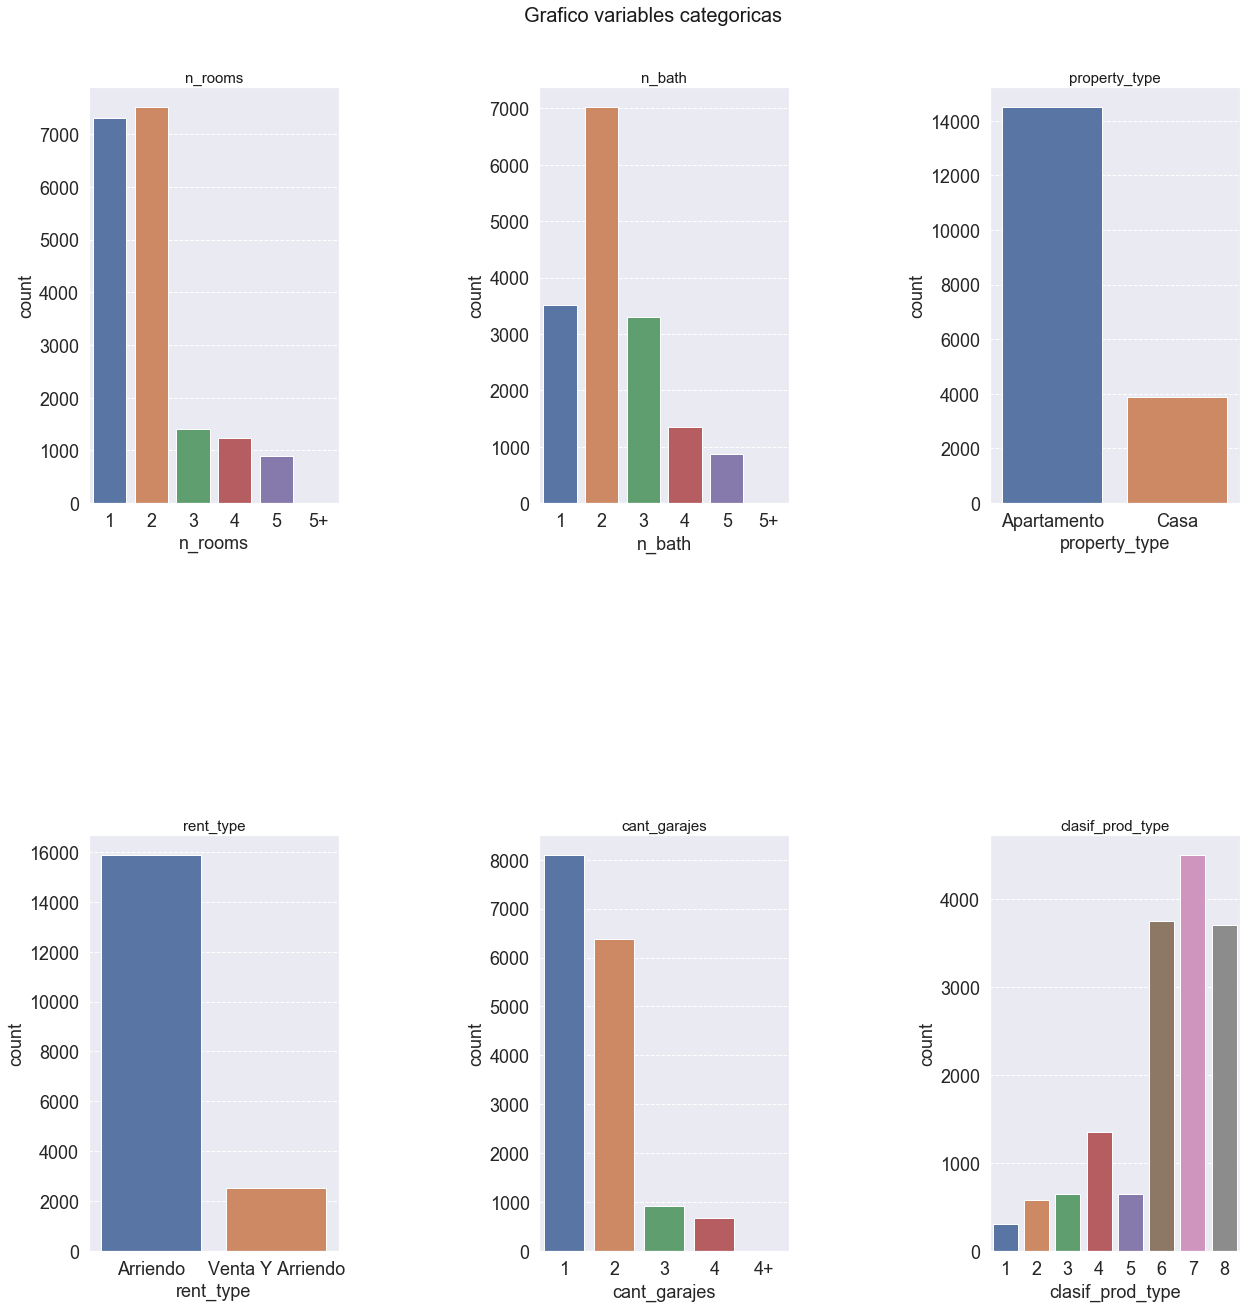

In [322]:
plot_order = {'n_rooms': [ '1', '2', '3', '4', '5', '5+'],
              'n_bath': [ '1', '2', '3', '4', '5', '5+'],
              'property_type': ['Apartamento', 'Casa'],
              'rent_type': ['Arriendo', 'Venta Y Arriendo'],
              'cant_garajes': ['1', '2', '3', '4', '4+'],
              'clasif_prod_type': [i for i in range(1,9)]
             }
plot_categorical_vars(data,categorical,'Grafico variables categoricas',plot_order)
#len(categorical)

De las distribuciones de las variables categoricas, es posible inferir que la variable `rent_type` no aporta mucha informacion al momento de inferir el precio por metro$^2$. Esto debido a la alta concentracion en uno de los valores. Se puede inferir lo mismo de la variable `property_type`. 

Para comprender mejor que informacion me aportan las distintas columnas para resolver el problema, es bueno identificar la varible objetivo o _target_ y hacer graficas comparativas con esta.

Como la variable _target_ es el precio cuadrado por metro cuadrado, a continuacion se implementa una funcion para Estudiar como se relacionan estas variables. Para las variables categoricas, el tipo de grafico utilizado es el boxplot o el grafico de violin. Para las variables numericas se utiliza el _scatter plot_. Dado el rango de precio por $metro^2$, es importante que exista la opcion de escalar el eje y.

In [323]:
def plot_violin(target, col, order = None, scale = False ,df = data):
    '''
    Para variables categoricas v/s una variable target. Las variables categoricas deben ser de baja
    cardinalidad, sino el grafico no es util.
    Genera grafico de violin e histograma con distribucion de la variable a comparar.
    Recibe el nombre de la variable objetivo y la variablecon la cual se desea comparar.
    
    Args:
    --------
    target: String
        Nombre de la columna objetivo (eje y).
    col: String 
        Nombre de la columna que representara el eje x.
    scale: Bool
        Si se quiere o no escalar el eje y. Util cuando el rango de esta variable es muy grande. 
        
    Returns: None
        Muestra en pantalla dos graficos: Violin plot (similar al boxplot) y el histograma de 
        la variable col.
        
    Ejemplo de uso:
    --------------
    plot_violin('price_per_m2','n_rooms')
    '''
    sns.set(rc=custom)
    
    # Sirve para fija el tamaño de lasetiquetas del plot
    fontdict = {'fontsize':20}

    # Estrucutra de figura y axes
    fig, ax = plt.subplots(2,1,figsize=[12,13])

    # violin plot --> equivalente a catplot(kind = 'violin')
    if scale:
        sns.violinplot(col,
                    y=(target),
                    data=df,
                    kind='violin',
                    ax=ax[0],
                    order = order).set_yscale("log")
    else:
        sns.violinplot(col,
            y=(target),
            data=df,
            kind='violin',
            ax=ax[0],
            order = order)

    sns.countplot(df[col], ax=ax[1], order = order)

    ax[0].set_xlabel(col, fontdict)
    ax[1].set_xlabel(col, fontdict)

    ax[0].set_ylabel(target, fontdict)
    title = 'Violin plot ' + col + ' v/s ' + target
    ax[0].set_title(title, fontdict)
    title_y = "Frecuencias " + col
    ax[1].set_title(title_y, fontdict)
    

    h, w = (.3, .1)
    plt.subplots_adjust(wspace=w, hspace=h)

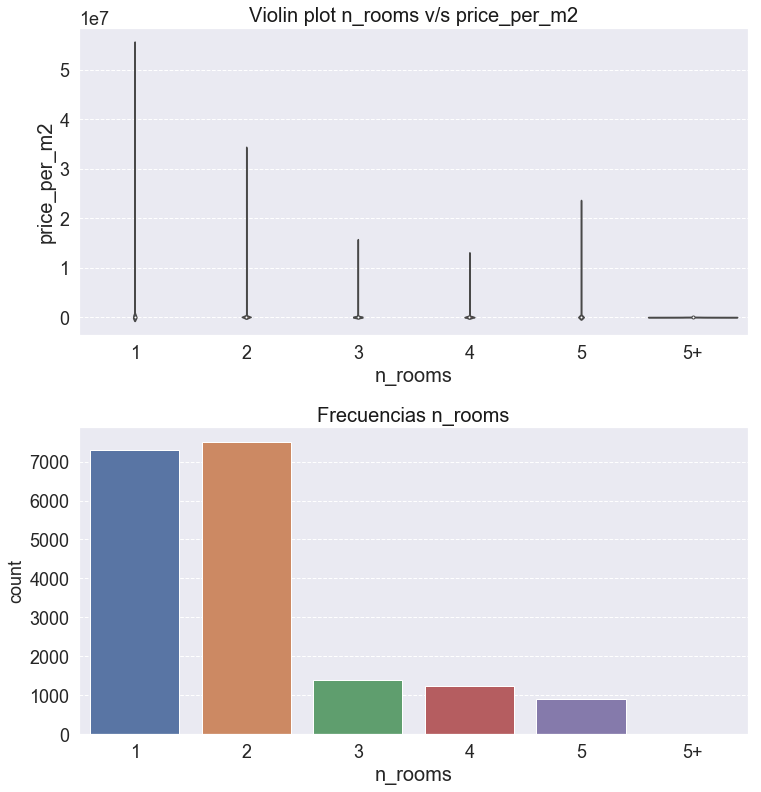

In [324]:
plot_violin('price_per_m2','n_rooms', order = plot_order['n_rooms'])

Observemos que, debido al rango de la variable `price_per_m2`, es dificil obtener visualizaiones buenas de la relacion entre las variables. Por esto, se acotara en adelante el precio por m2 para que este en el rango [10000, 100000]. Esto solo se realizara para las visualizaciones y el perfilamiento. Por esto se creara un nuevo DataFrame `new_data`.  

In [325]:
new_data = data.copy()
new_data = new_data[new_data.price_per_m2 < 100000]
new_data = new_data[new_data.price_per_m2 > 10000]
'''De esta forma tambien es posible eliminar outliers.'''

print('Largo original del DataFrame: ',len(data))
print('Largo del nuevo DataFrame: ', len(new_data))
print('Maximo precio por m2 del nuevo DataFrame: ', max(new_data.price_per_m2))

Largo original del DataFrame:  18393
Largo del nuevo DataFrame:  18020
Maximo precio por m2 del nuevo DataFrame:  96923.07692307692


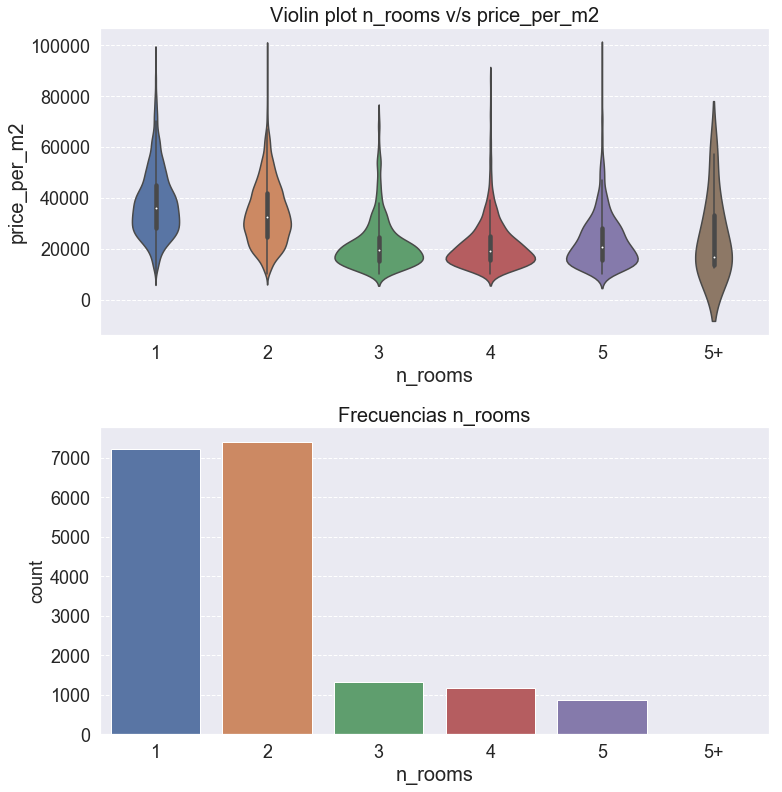

In [326]:
#Grafico para cantidad de piezas vs precio por m2
plot_violin('price_per_m2','n_rooms', order = plot_order['n_rooms'],scale = False ,df = new_data)

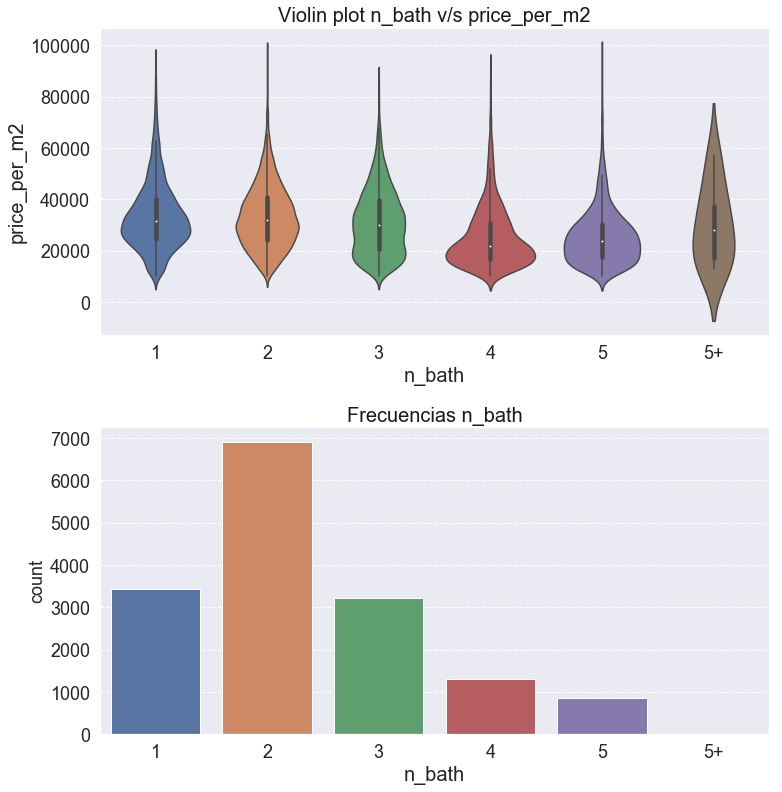

In [327]:
#Grafico para cantidad de piezas vs precio por m2
plot_violin('price_per_m2','n_bath', df = new_data, order = plot_order['n_bath'])

Se observa que, aunque muy leve, existe una relacion entre `price_per_m2` y `n_rooms`. En especial si se toman en cuenta solo los valores pertenecientes a [1, 2, 3, 4, 5] Por otro lado, es claro que las propiedades con 1 y 2 dormitorios son las que predominan.

La variable `n_bath` tiene un comportamiento similar 

Observemos ahora como se relaciona la clasificacion de la propiedad v/s el precio por $metro^2$:

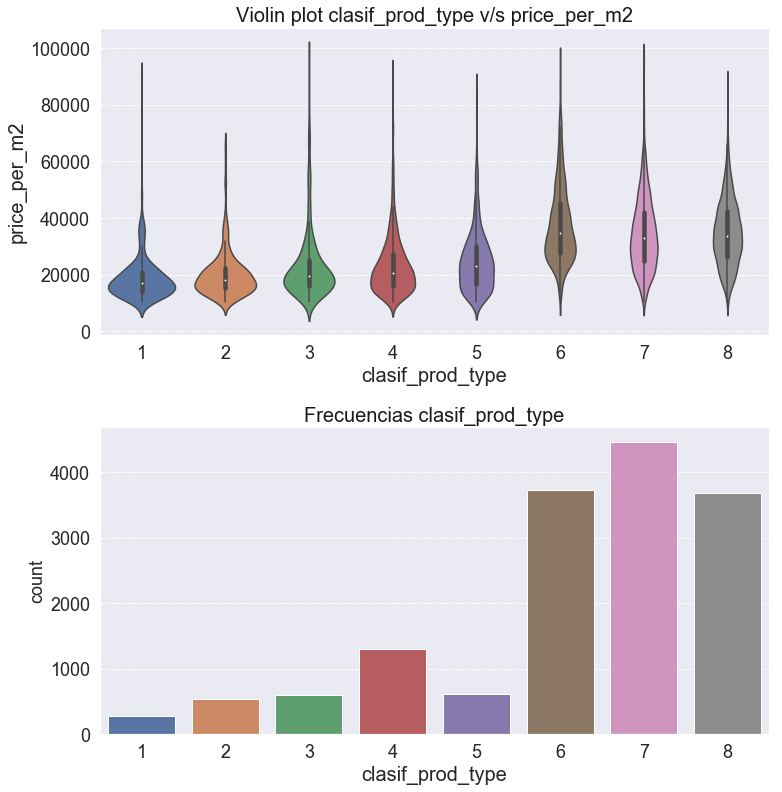

In [328]:
plot_violin('price_per_m2','clasif_prod_type', df = new_data, order = plot_order['clasif_prod_type'])

Como se observa en la primera imagen correspondiente a los graficos de violin, se observa una leve pendiente positiva: a medida que aumenta el numero correspondiente a la clasificacion del producto, aumenta (aunque levemente) el precio por $metro^2$. Esta variable sera de interes mas adelante porque ademas no presenta una concentracion en una clase particular tan alta como en el caso de `n_rooms`. 

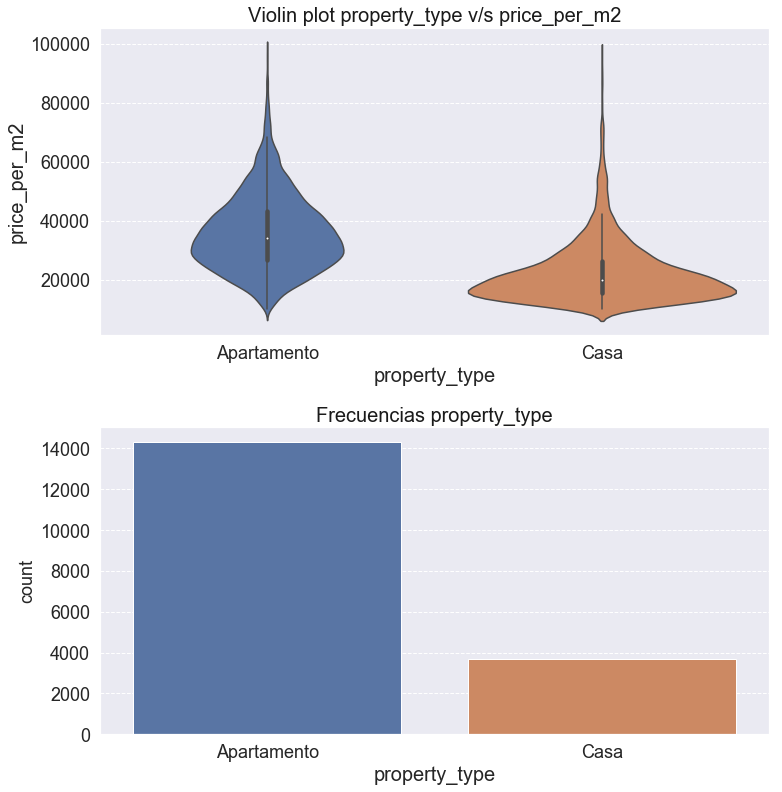

In [329]:
plot_violin('price_per_m2','property_type', df = new_data, order = plot_order['property_type'])

Se observa que el precio por metro$^2$ de apartamento es algo mas caro que el de las casas. Por otro lado, hay una gran diferencia en la cantidad de casas y apartamentos.

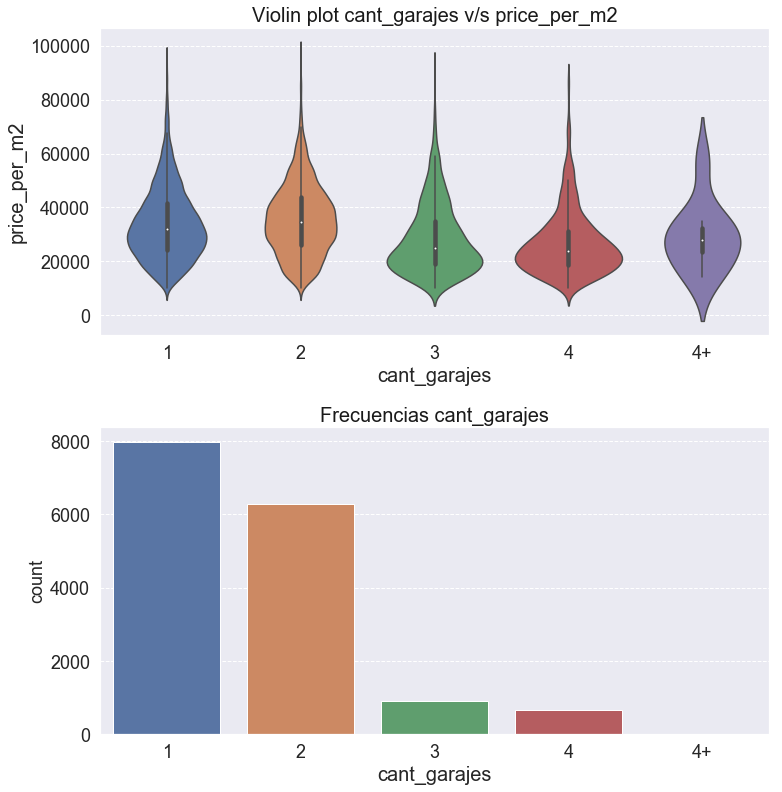

In [330]:
plot_violin('price_per_m2','cant_garajes', df= new_data, order = plot_order['cant_garajes'])

La variable `cant_garajes` tiene un comportamiento muy similar a las variables `n_bath` y `n_rooms`, pero su distribucion esta mas concentrada en 1 y 2.

A continuacion se procede a realizar los mismos graficos: variables numericas v/s precio por metro$^2$:

In [331]:
def plot_scatter(target, col, reg = True, scale = False, df = data):
    '''
    Para variables numericas v/s una variable target. 
    Genera el scatterplot e histograma con distribucion de la variable a comparar.
    Recibe el nombre de la variable objetivo y la variablecon la cual se desea comparar.
    
    Args:
    --------
    target: String
        Nombre de la columna objetivo (eje y).
    col: String 
        Nombre de la columna que representara el eje x.
    reg: Bool
        Si se incluye o no una regresion lineal sobre los datos.
    scale: Bool
        Si se quiere o no escalar el eje y. Util cuando el rango de esta variable es muy grande. 
        
    Returns: None
        Muestra en pantalla dos graficos: Violin plot (similar al boxplot) y el histograma de 
        la variable col.
        
    Ejemplo de uso:
    --------------
    plot_scatter('price_per_m2','price')
    '''
    
    sns.set(rc=custom)
    
    # Sirve para fija el tamaño de lasetiquetas del plot
    fontdict = {'fontsize':20}

    # Estrucutra de figura y axes
    fig, ax = plt.subplots(2,1,figsize=[10,10])

    # violin plot --> equivalente a catplot(kind = 'violin')
    if scale:
        if reg:
            sns.regplot(x = col,
                        y= target,
                        data=df,
                        ax=ax[0]).set_yscale("log")
            title = 'Scatter plot ' + col + ' v/s log(' + target + ') con ajuste lineal.'
            ax[0].set_title(title, fontdict,y=1.05)
        else:
            sns.scatterplot(x = col,
                            y=target,
                            data=df,
                            ax=ax[0]).set_yscale("log")
            title = 'Scatter plot ' + col + ' v/s log(' + target + ')'
            ax[0].set_title(title, fontdict,y=1.05)
    else:
        if reg:
            sns.regplot(x = col,
                        y= target,
                        data=df,
                        ax=ax[0])
            title = 'Scatter plot ' + col + ' v/s ' + target + ' con ajuste lineal.'
            ax[0].set_title(title, fontdict,y=1.05)
        else:
            sns.scatterplot(x = col,
                            y=target,
                            data=df,
                            ax=ax[0])
            title = 'Scatter plot ' + col + ' v/s ' + target
            ax[0].set_title(title, fontdict ,y=1.05)

    sns.distplot(df[col], ax=ax[1])

    ax[0].set_xlabel(col, fontdict)
    ax[1].set_xlabel(col, fontdict)

    ax[0].set_ylabel(target, fontdict)
    
    title_y = "Frecuencias " + col
    ax[1].set_title(title_y, fontdict,y=1.05)
    

    h, w = (.6, .1)
    plt.subplots_adjust(wspace=w, hspace=h)

Antes de continuar con el analisis de las variables numericas, es importante ver como cambia la distribucion de tres de estas desde que se fijo un limite superior y uno inferior para `price_per_m2`:

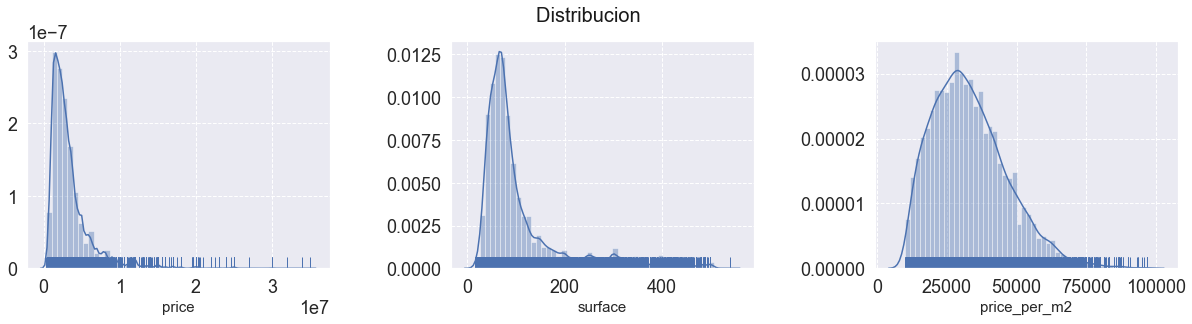

In [332]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[17, 4])

fig.tight_layout()
    
#Ponemos el titulo:
fig.suptitle('Distribucion ',
         fontsize=20,
         x=0.5,
         y=1.05)
vars_a_graficar = ['price','surface','price_per_m2']
#Se recorre cada axis, para cada columna del dataframe, se genera un grafico 
#distinto en funcion del tipo de dato.
for axis, col in zip(ax.flatten(), vars_a_graficar):
    try :
        # Graficos para datos numericos
        sns.distplot(new_data[(col)], ax=axis, rug=True)

    except RuntimeError:
        sns.distplot(new_data[(col)], ax=axis, rug=True, kde=False)

    axis.set_xlabel(col, fontsize=15)

# Se ajusta el espaciado interno entre subplots
w, h = (.4, .4)
plt.subplots_adjust(wspace=w, hspace=h)


Observemos que al fijar un rango para `price_per_m2` y eliminar los datos que sobrepasan este rango, cambia notoriamente la distribucion de `price` y de `surface`. 

A continuacion se muestan los _scatterPlot_ de algunas variables de interes v/s el precio por metro cuadrado. Se observan las variables `metrocuadrado_index`, `indice_envegecimiento`, `UPZ_area`, `UTZ_density` y `jefe_mujer_perc` ya que se observa que son variables poco concentradas. 
Es importante mencionar que las variables `price` y `surface` no se incluyen en el analisis ya que precio por metro$^2$ se construye a partir de estas dos.

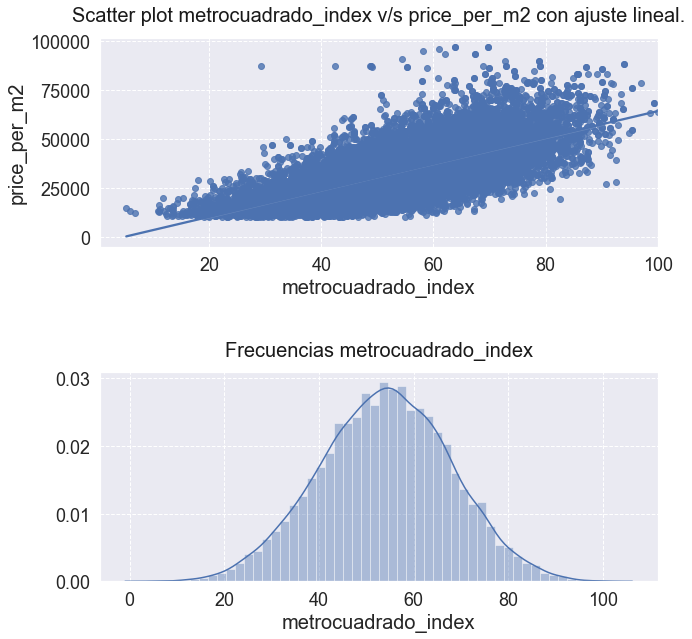

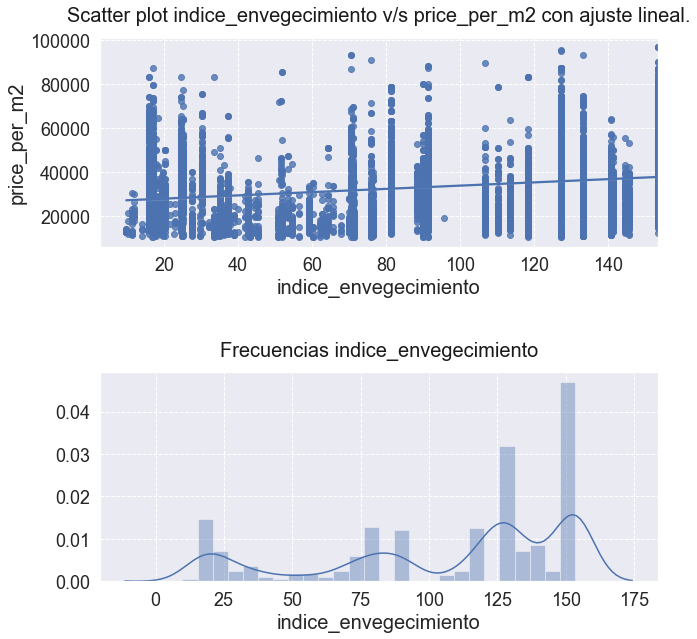

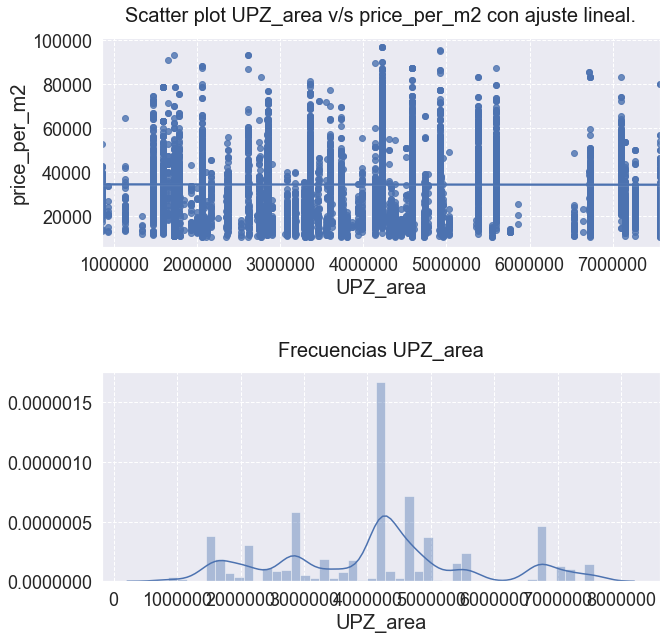

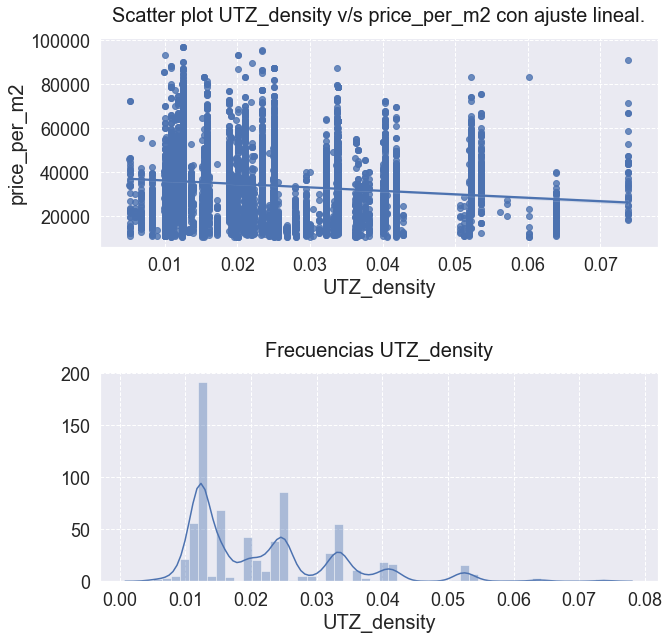

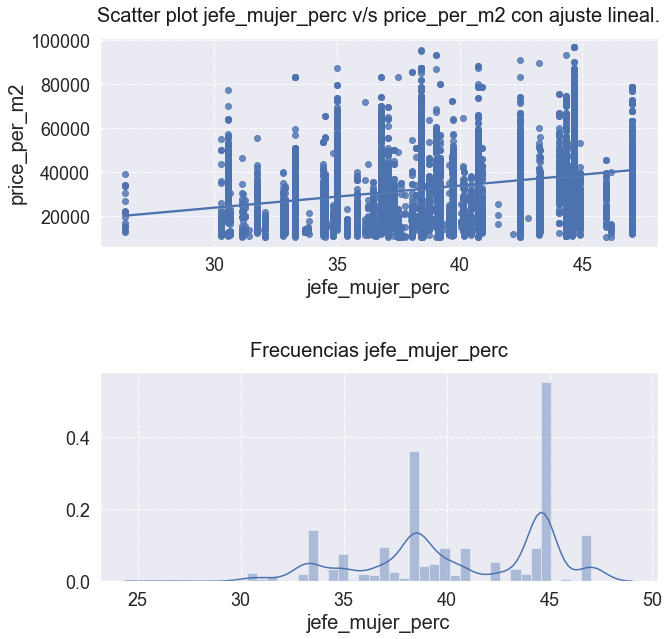

In [333]:
var_de_interes = ['metrocuadrado_index', 'indice_envegecimiento', 'UPZ_area', 'UTZ_density', 'jefe_mujer_perc']
for var in var_de_interes:
    plot_scatter('price_per_m2', var, df = new_data)

De esta forma, se observa una clara relacion lineal entre `metrocuadrado_index` y `price_per_m2`. De igual forma, el ajuste lineal en las variables `jefe_mujer_perc` e `indice_envegecimiento` indican una relacion entre estas y `price_per_m2` pero con una observacion detenida se puede inferir que probablemente no presenten una dependencia lineal entre ellas. De todas formas, debido a que no presentan grandes concentraciones en valores particulares, seguiran siendo de interes mas adelante. 


Como se menciono anteriormente, hay un grupo de variables que no se estudio. Estas corresponden a `details`, `url`, `UPZ`, `location`. A continuacion se realizara un estudio breve de `UPZ` y `location`. Para esto, se codificaran las distintas etiquetas como numeros para que sea mas facil realizar graficos. El funcionamiento del _LabelEncoder_ se muestra a continuacion:

```python
le = preprocessing.LabelEncoder()
le.fit(["paris", "paris", "tokyo", "amsterdam"])
LabelEncoder()
list(le.classes_)
['amsterdam', 'paris', 'tokyo']
le.transform(["tokyo", "tokyo", "paris"])
array([2, 2, 1]...)
list(le.inverse_transform([2, 2, 1]))
['tokyo', 'tokyo', 'paris']
```

[Fuente ejemplo y documentacion LabelEncoder sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [334]:
#Codificacion de UPZ
from sklearn import preprocessing
new_data.UPZ = new_data['UPZ'].astype('str')

le_UPZ = preprocessing.LabelEncoder()
le_UPZ.fit(new_data.UPZ.unique())

UPZ_code = le_UPZ.classes_
new_data['UPZ_cat'] = le_UPZ.transform(new_data.UPZ)

print('='*20 + '   Codificacion UPZ   ' + '='*20)
print(UPZ_code)
print(le_UPZ.inverse_transform([0,0,1,2,3,4]))


#Codificacion de location:
le_location = preprocessing.LabelEncoder()
le_location.fit(new_data.location.unique())

location_code = le_location.classes_
new_data['location_cat'] = le_location.transform(new_data.location)

print('\n'*2 + '='*20 + '   Codificacion Location   ' + '='*20)
print('Location code: ', location_code[0:10])
print(le_location.inverse_transform([0,0,1,2,3,4]))

====================   Codificacion UPZ   ====================
['UPZ10' 'UPZ100' 'UPZ101' 'UPZ102' 'UPZ103' 'UPZ104' 'UPZ105' 'UPZ106'
 'UPZ107' 'UPZ108' 'UPZ11' 'UPZ110' 'UPZ111' 'UPZ112' 'UPZ113' 'UPZ114'
 'UPZ115' 'UPZ12' 'UPZ13' 'UPZ14' 'UPZ15' 'UPZ16' 'UPZ17' 'UPZ18' 'UPZ19'
 'UPZ2' 'UPZ20' 'UPZ21' 'UPZ22' 'UPZ23' 'UPZ24' 'UPZ25' 'UPZ26' 'UPZ27'
 'UPZ28' 'UPZ29' 'UPZ30' 'UPZ31' 'UPZ33' 'UPZ34' 'UPZ35' 'UPZ36' 'UPZ37'
 'UPZ38' 'UPZ39' 'UPZ40' 'UPZ41' 'UPZ42' 'UPZ43' 'UPZ44' 'UPZ45' 'UPZ46'
 'UPZ47' 'UPZ48' 'UPZ49' 'UPZ50' 'UPZ53' 'UPZ54' 'UPZ55' 'UPZ57' 'UPZ58'
 'UPZ59' 'UPZ65' 'UPZ66' 'UPZ67' 'UPZ68' 'UPZ69' 'UPZ70' 'UPZ71' 'UPZ72'
 'UPZ73' 'UPZ75' 'UPZ76' 'UPZ77' 'UPZ78' 'UPZ79' 'UPZ80' 'UPZ81' 'UPZ82'
 'UPZ83' 'UPZ84' 'UPZ85' 'UPZ86' 'UPZ87' 'UPZ88' 'UPZ89' 'UPZ9' 'UPZ90'
 'UPZ91' 'UPZ92' 'UPZ93' 'UPZ94' 'UPZ95' 'UPZ96' 'UPZ97' 'UPZ98' 'UPZ99'
 'nan']
['UPZ10' 'UPZ10' 'UPZ100' 'UPZ101' 'UPZ102' 'UPZ103']


====================   Codificacion Location   ====================
Locat

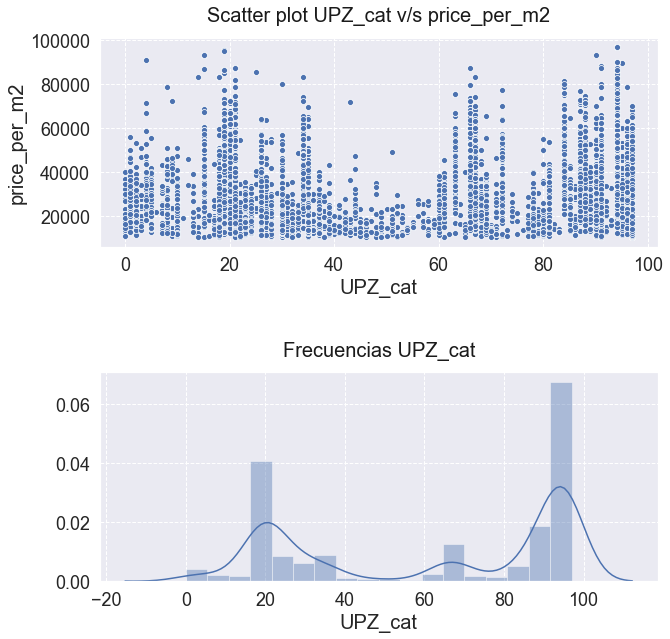

In [335]:
plot_scatter('price_per_m2', 'UPZ_cat', reg = False ,df = new_data)

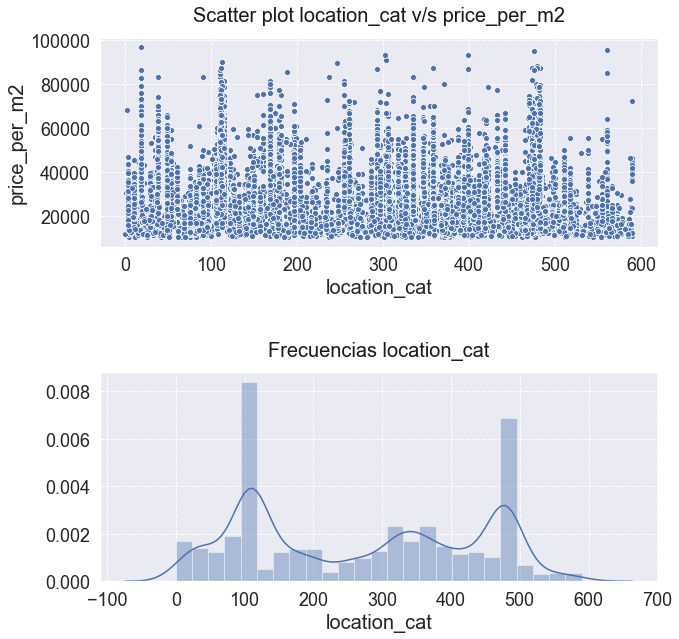

In [336]:
plot_scatter('price_per_m2', 'location_cat', df = new_data, reg = False)

Se observa que tanto en `UPZ` como en `location` no hay grandes concentraciones en valores especificos. Mas informacion no se puede obtener debido a que los numeros en el eje x son una representacion de los strings asociados a esa columna.

#### Perfilamiento Bivariado:
Para comenzar el perfilamiento bivariado se emplean visualizaciones a pares. De esta forma podemos observar las relaciones entre las distintas variables. 

In [337]:
categorical

['n_rooms',
 'n_bath',
 'property_type',
 'rent_type',
 'cant_garajes',
 'clasif_prod_type']

In [338]:
interes = ['price_per_m2', 'metrocuadrado_index', 'indice_envegecimiento', 'UPZ_area', 'UTZ_density', 
           'jefe_mujer_perc', 'clasif_prod_type']

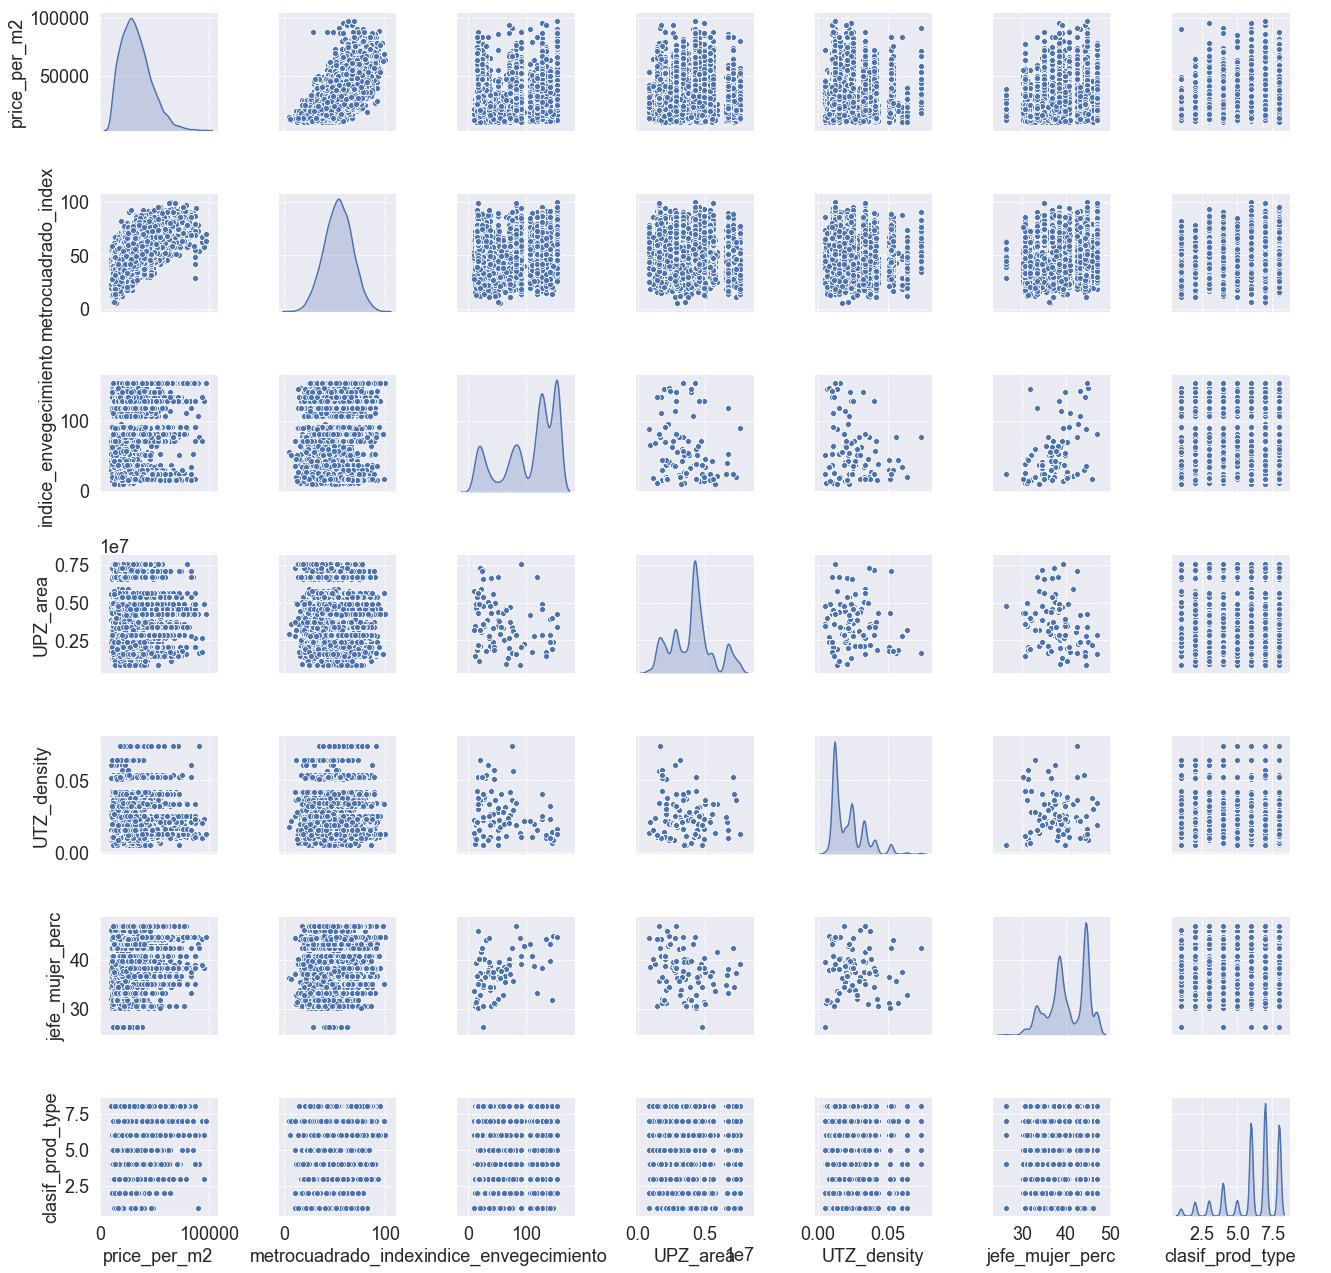

In [339]:
sns.pairplot(data = new_data[interes], diag_kind='kde')

La primera columna nos muestra la relacion entre `price_per_m2` y las demas variables de interes. Al igual que antes, es dificil extraer informacion valiosa de relaciones entre variables a simple vista de los graficos. Para comprobar que esto no sea debido a los `price_per_m2` que escapaban los 100000, se realizara el mismo grafico con `new_data`:

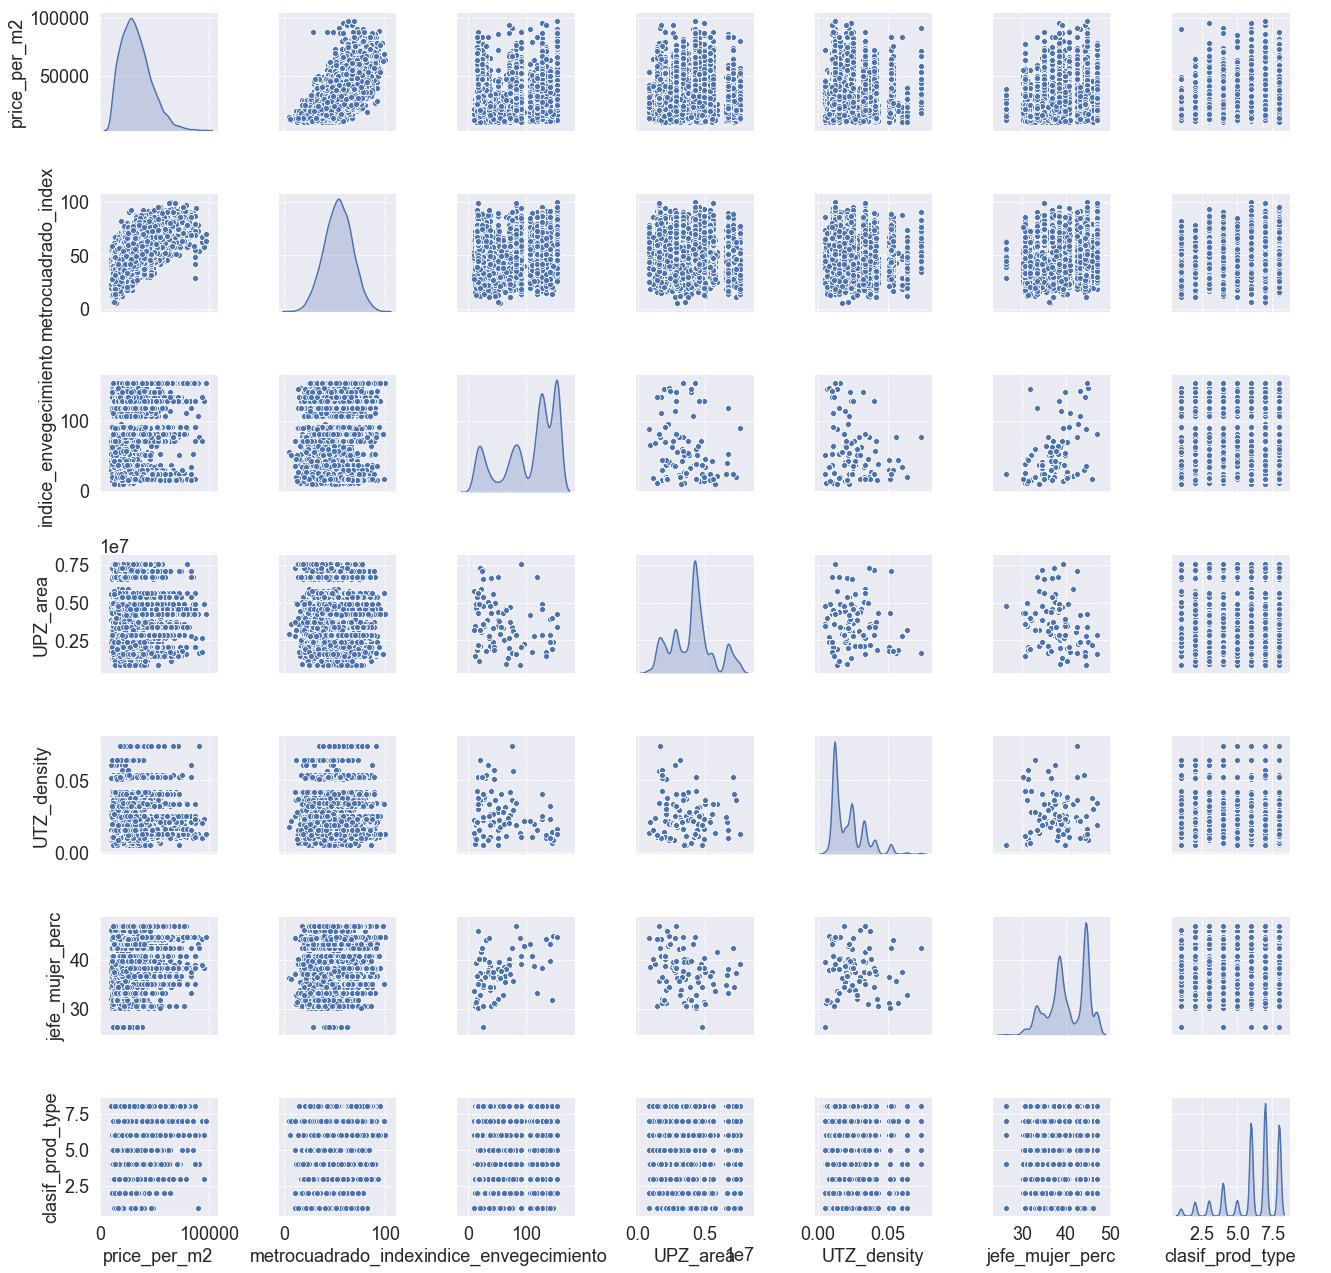

In [340]:
sns.pairplot(data = new_data[interes], diag_kind='kde')

Como en el caso del perfilamiento univariado de las variables numericas, trabajar con los datos correspondientes a `price_per_m2` menores a 100000 entrega informacion sobre las relaciones de las variables: En primer lugar, se vuelve a observar el comportamiento `price_per_m2` v/s `metrocuadrado_index`. Luego se observa que la variable `clasif_prod_type` se comporta de forma similar v/s todas las variables de interes. 


Para entender como se relacionan las variables entre ellas, es de utilidad el mapa de calor:

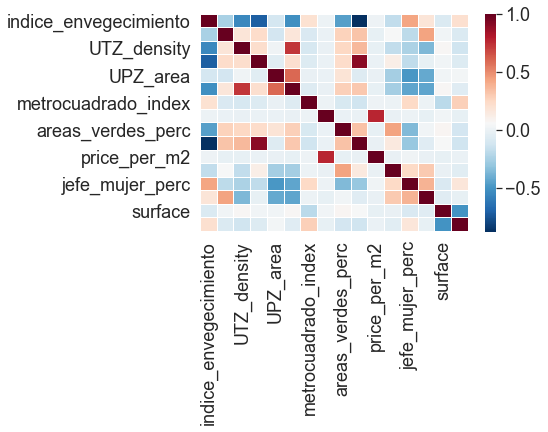

In [341]:
sns.heatmap(data.corr(), linewidths=.01, cmap = 'RdBu_r')

# Juegos para feature selection.

In [342]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, chi2
from sklearn import metrics

In [343]:
#car es la cantidad de caracteristicas que queremos
def selectFeatures(datos,etiquetas,car):
    return SelectKBest(f_regression, k=car).fit_transform(datos,etiquetas)

#Separamos en conjunto de entrenamiento, validacion y prueba
def getConjuntos(datos,label,por):
    return train_test_split(datos, label, test_size=por, random_state=42)

In [344]:
data_X_cols = [col for col in new_data.columns if col != 'price_per_m2']

data_X = new_data.dropna()

data_Y = data_X.price_per_m2

interes = interes + ['UPZ_cat','location_cat']

data_col = [col for col in interes if col != 'price_per_m2']
data_X = data_X[data_col]

#data_x = selectFeatures(data_X, data_Y, 3)

In [345]:
interes

['price_per_m2',
 'metrocuadrado_index',
 'indice_envegecimiento',
 'UPZ_area',
 'UTZ_density',
 'jefe_mujer_perc',
 'clasif_prod_type',
 'UPZ_cat',
 'location_cat']

In [346]:
# Create and fit selector
selector = SelectKBest(f_regression, k=4)
selector.fit(data_X, data_Y)

# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
features_df_new = data_X.iloc[:,cols]


In [347]:
features_df_new

,metrocuadrado_index,jefe_mujer_perc,clasif_prod_type,UPZ_cat
5,47.1,36.279630,1.0,17
14,55.9,38.443910,1.0,19
19,39.6,36.465059,1.0,23
27,28.7,26.367889,1.0,13
29,67.3,36.582791,1.0,77
...,...,...,...,...
18385,33.6,33.286852,6.0,18
18388,42.2,38.443910,6.0,21
18390,72.7,33.286852,6.0,18
18391,63.4,35.008129,7.0,66


Codifiquemos las variables location y upz:

In [348]:
from sklearn.cluster import KMeans
import sys

In [349]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(features_df_new)
    distortions.append(kmeanModel.inertia_)

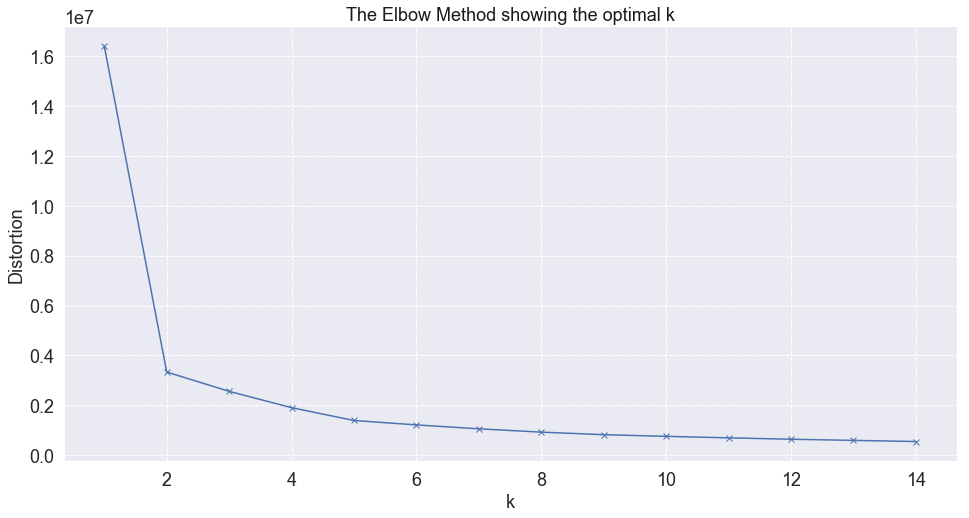

In [350]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.yscale('linear')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [351]:
print(len(features_df_new['metrocuadrado_index']), len(features_df_new['UPZ_cat']))

12249 12249


Text(0.5, 1.0, 'Actual')

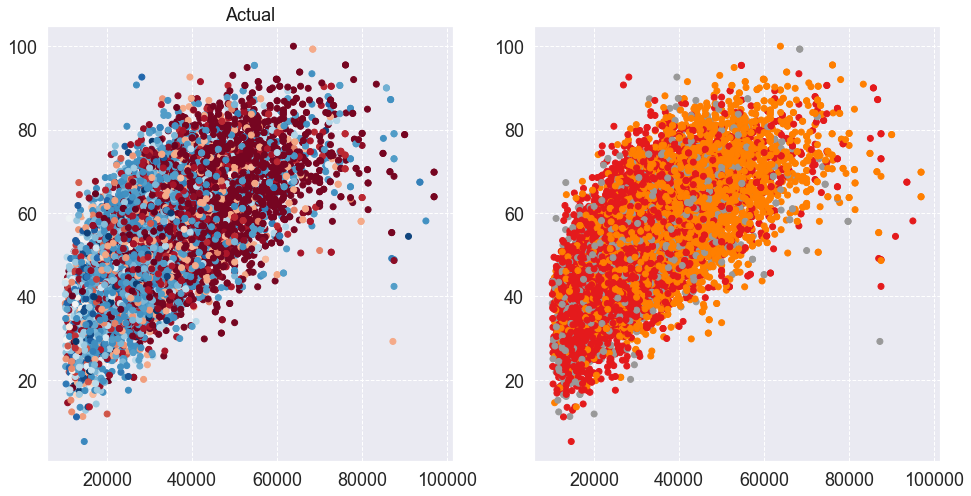

In [358]:
new_data[interes].dropna()

new_data = new_data[~new_data.isin([np.nan, np.inf, -np.inf]).any(1)]

kmeanModel = KMeans(n_clusters=3)
kmeanModel.fit(new_data[interes])

#K-Means vs Actual for n_clusters=3

new_data['k_means']=kmeanModel.predict(new_data[interes])
new_data['target']=new_data['UPZ_cat']

fig, axes = plt.subplots(1, 2, figsize=(16,8))

axes[0].scatter(new_data['price_per_m2'], new_data['metrocuadrado_index'], c=features_df_new['target'])
axes[1].scatter(new_data['price_per_m2'], new_data['metrocuadrado_index'], c=features_df_new['k_means'], cmap=plt.cm.Set1)
axes[0].set_title('Actual', fontsize=18)
